In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import scanpy as sc
import dynamo as dyn
import spateo as st
warnings.filterwarnings("ignore")

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packag

In [3]:
cpo = [(393, 1084, 9), (9, 5, -2), (0, 0, 1)]
mapping_cpo = [(-28, 1021, -119), (-29, 9, -152), (0, 0, 1)]

In [4]:
tissue, morpho_id = "amnioserosa", "morphogenesis"
sample_id1, sample_id2 = "E7_8h", "E8_9h"
os.chdir(f"/media/pc001/Yao/Projects/Project_spateo/mouse_heart/figure6")

out_h5ad_path = f"droso_{sample_id1}_GBA_morpho/h5ad"
out_image_path = f"droso_{sample_id1}_GBA_morpho/image/amnioserosa_mapping"
Path(out_image_path).mkdir(parents=True, exist_ok=True)
Path(out_h5ad_path).mkdir(parents=True, exist_ok=True)
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [14]:
# Read anndata
n_top_genes = 200
stage1_adata = st.read_h5ad(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id1}/h5ad/{sample_id1}_cellbin_clean.h5ad")
stage1_adata.X = stage1_adata.layers["X_counts"]
stage1_adata.obsm["3d_align_spatial"] = stage1_adata.obsm["tdr_spatial"]
stage1_adata = stage1_adata[stage1_adata.obs["anno_tissue_new"] == tissue, :]
stage1_adata.X = stage1_adata.layers["X_counts"].copy()
stage1_adata = stage1_adata[stage1_adata.X.sum(axis=1) != 0, stage1_adata.X.sum(axis=0) != 0]
raw_stage1_adata = stage1_adata.copy()
sc.pp.highly_variable_genes(stage1_adata, n_top_genes=n_top_genes)
stage1_adata = stage1_adata[:, stage1_adata.var["highly_variable"]]
sc.pp.normalize_total(adata=stage1_adata)
sc.pp.log1p(stage1_adata)

stage2_adata = st.read_h5ad(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id2}/h5ad/{sample_id2}_cellbin_v2_{tissue}.h5ad")
stage2_adata.X = stage2_adata.layers["X_counts"].copy()
stage2_adata = stage2_adata[stage2_adata.X.sum(axis=1) != 0, stage2_adata.X.sum(axis=0) != 0]
sc.pp.highly_variable_genes(stage2_adata, n_top_genes=n_top_genes)
stage2_adata = stage2_adata[:, stage2_adata.var["highly_variable"]]
sc.pp.normalize_total(adata=stage2_adata)
sc.pp.log1p(stage2_adata)
print(stage1_adata, stage2_adata)

AnnData object with n_obs × n_vars = 769 × 201
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: '2d_realign_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', '3d_align_spatial'
    layers: 'X_counts', 'spliced', 'unspliced' AnnData object with n_obs × n_vars = 969 × 200
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'


## Mapping

In [15]:
# Cell mapping
_, pi = st.tdr.cell_directions(
    adataA=stage1_adata,
    adataB=stage2_adata,
    numItermaxEmd=2000000,
    # G_init=pi_init,
    spatial_key="3d_align_spatial",
    key_added="cells_mapping",
    alpha=0.001,
    device="0",
    inplace=True,
)

|-----> Filtered all samples for common genes. There are 36 common genes.


## Check mapping result

In [16]:
stage1_tissue_pc, _ = st.tdr.construct_pc(
    adata=stage1_adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue_new",
    key_added="tissue",
    colormap={"amnioserosa": "#bdcf32", "CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "salivary gland": "#ef9b20",},
)

stage2_tissue_pc, _ = st.tdr.construct_pc(
    adata=stage2_adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue_new",
    key_added="tissue",
    colormap={"amnioserosa": "#bdcf32", "CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "salivary gland": "#ef9b20",},
)
models_distance = np.asarray([0, 0, -260])
stage2_tissue_pc.points = stage2_tissue_pc.points + models_distance
stage2_adata

AnnData object with n_obs × n_vars = 969 × 200
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

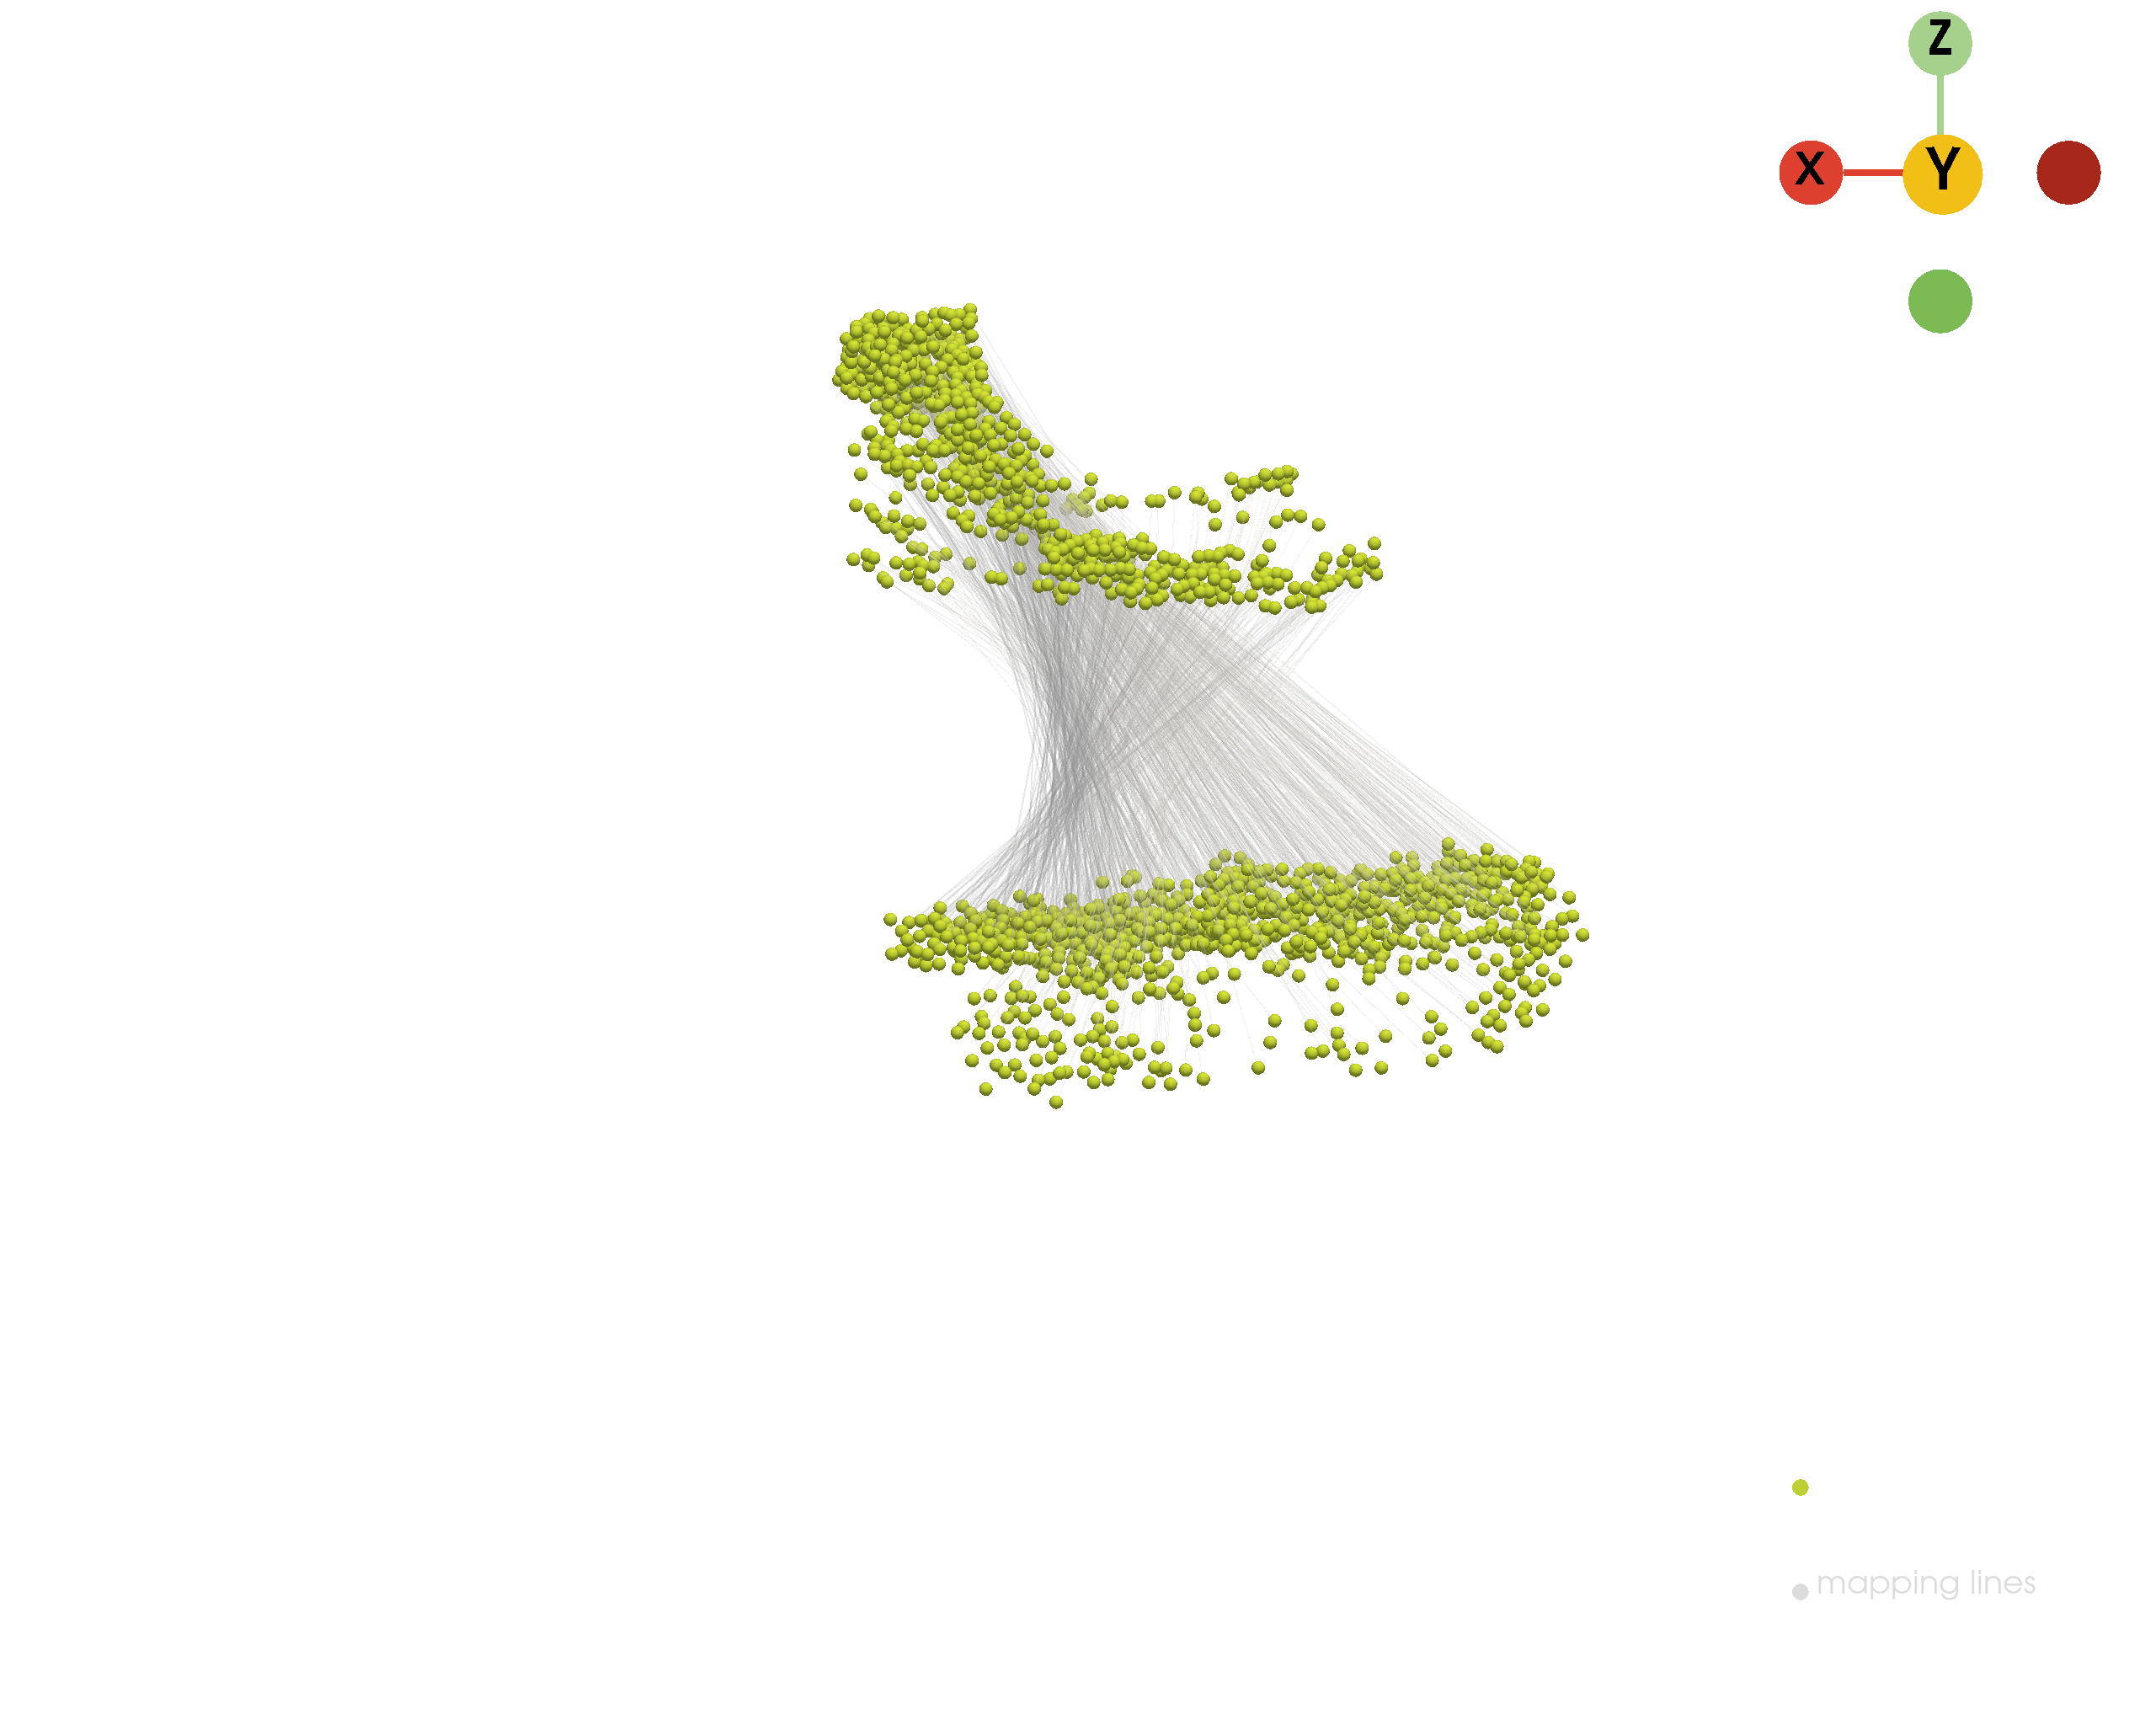

In [17]:
model_lines, _ = st.tdr.construct_align_lines(
            model1_points=stage1_adata.obsm["3d_align_spatial"].copy(),
            model2_points=stage1_adata.obsm["X_cells_mapping"] + models_distance,
            key_added="mapping",
            label="mapping lines",
            color="gainsboro",
            alpha=1.0,
        )

mapping_cpo = [(18, 1370, -141),(-1.8, 5.8, -156.8), (0, 0, 1)]
st.pl.three_d_plot(
        model=st.tdr.collect_models([model_lines, st.tdr.merge_models([stage1_tissue_pc, stage2_tissue_pc])]),
        key=["mapping", "tissue"],
        jupyter="static",
        cpo=mapping_cpo,
        background="white",
        window_size=(2560, 2048),
        opacity=[0.1, 1],
        model_style=["wireframe", "points"],
        model_size=[2, 16],
        filename=os.path.join(out_image_path, f"E7-8h-E8-9h_amnioserosa_mapping_z_model_260.pdf"),
    )

In [18]:
raw_stage1_adata.X = raw_stage1_adata.layers["X_counts"]
raw_stage1_adata.obsm["X_cells_mapping"] = stage1_adata.obsm["X_cells_mapping"]
raw_stage1_adata.obsm["V_cells_mapping"] = stage1_adata.obsm["V_cells_mapping"]
raw_stage1_adata.uns["__type"] = "UMI"
raw_stage1_adata.write_h5ad(os.path.join(out_h5ad_path, f"{sample_id1}_mapping_{tissue}.h5ad"), compression="gzip",)
raw_stage1_adata

AnnData object with n_obs × n_vars = 769 × 6729
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    uns: '__type'
    obsm: '2d_realign_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', '3d_align_spatial', 'X_cells_mapping', 'V_cells_mapping'
    layers: 'X_counts', 'spliced', 'unspliced'